
# Random Forest


# Setup Functions

In [ ]:
#@title Run to Set Up
!pip install -U wget
!rm -rf data.zip data lib
!mkdir lib

import wget
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/lib/config.yaml', 'lib/config.yaml')
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/lib/helper.py', 'lib/helper.py')
wget.download('https://github.com/comp-hci-lab/BDSI_2021_ML/raw/master/data.zip', 'data.zip')

import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=71fcc2b242729798dcc75915403a0da50f8bc432acc97f460fa5e04d401480ed
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics, exceptions

from lib.helper import load_data
from lib.helper import load_data, config
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import RandomizedSearchCV


In [ ]:
N = 10000 # we are selecting first 2500 participant for this tutorial (you can choose upto 10k)
raw_data, df_labels = load_data(N)

Loading files from disk: 100%|██████████| 10000/10000 [00:29<00:00, 340.95it/s]


In [ ]:
len(raw_data)

10000

In [ ]:
df_labels.shape

(10000, 3)

In [ ]:
df_labels.head()

,RecordID,In-hospital_death,30-day_mortality
0,132539,-1.0,-1.0
1,132540,-1.0,-1.0
2,132541,-1.0,-1.0
3,132543,-1.0,-1.0
4,132545,-1.0,-1.0


## Split code into 3 sets (2,500, 5,000, 2,500) for development, training, and testing

In [ ]:
from itertools import islice

inc = iter(raw_data.items())
raw_data_dev = dict(islice(inc, len(raw_data) // 4))
raw_data_train = dict(islice(inc, len(raw_data) // 2))
raw_data_test = dict(inc)

In [ ]:
print(len(raw_data_dev))
print(len(raw_data_train))
print(len(raw_data_test))

2500
5000
2500


In [ ]:
df_labels_dev = df_labels.iloc[:2500,:]
df_labels_train = df_labels.iloc[2500:7500,:]
df_labels_test = df_labels.iloc[7500:,:]

In [ ]:
df_2.shape

NameError: ignored

In [ ]:
#@title Define preprocessing functions. { display-mode: "form" }
#@markdown - `impute_missing_data(X)`
#@markdown - `normalize_feature_matrix(X)`
#@markdown - `generate_feature_vector(X)`
#@markdown - `series_to_supervised(data,var_name)`

from sklearn.impute import SimpleImputer
import pdb
from itertools import product


def impute_missing_data(X):
    """
    For each feature column, impute missing values  (np.nan) with the
    population mean for that feature.

    Args:
        X: np.array, shape (N, d). X could contain missing values
    Returns:
        X: np.array, shape (N, d). X does not contain any missing values
    """
    return SimpleImputer(strategy='constant',fill_value=-1).fit_transform(X)


def normalize_feature_matrix(X):
    """
    For each feature column, normalize all values to range [0, 1].

    Args:
        X: np.array, shape (N, d).
    Returns:
        X: np.array, shape (N, d). Values are normalized per column.
    """
    from sklearn.preprocessing import MinMaxScaler
    return MinMaxScaler().fit_transform(X)


def generate_feature_vector(df, window_number=1):
    """
    Reads a dataframe containing all measurements for a single patient
    within the first 48 hours of the ICU admission, and convert it into
    a feature vector.

    Args:
        df: pd.Dataframe, with columns [Time, Variable, Value]
        window_number: number of time frame windows to create

    Returns:
        a python dictionary of format {feature_name: feature_value}
        for example, {'Age': 32, 'Gender': 0, 'mean_HR': 84, ...}
    """
    static_variables = config['invariant']
    timeseries_variables = config['timeseries']

    # Replace unknow values
    df = df.replace({-1: np.nan})

    # Add windows to dataframe
    df = add_windows(df,window_number)

    # Split time invariant and time series
    static, timeseries = df.iloc[0:5], df.iloc[5:].copy()
    static = static.pivot('Time', 'Variable', 'Value')

    # Setup static
    feature_dict = static.iloc[0].to_dict()
    if (timeseries.size==0): return feature_dict

    # Setup timeseries
    stats = ['mean','missing','max','min','count','std','median','quant25','quant75']
    timeseries_dict = {};
    windows = list(range(0,window_number))

    for stat in stats:
      timeseries[stat+"Name"] = timeseries[['Variable','Window']].apply(lambda x:str(x[0])+stat+str(x[1]),axis=1)
      window_labels = [stat+str(w) for w in windows]
      labels = [e1+str(e2) for e1,e2 in product(timeseries_variables, window_labels)]
      if stat == 'missing':
        timeseries_dict.update(dict.fromkeys(labels,1))
      else:
        timeseries_dict.update(dict.fromkeys(labels,np.nan))

    means = timeseries[["meanName",'Value']].groupby(["meanName"]).mean()
    mean_values = means['Value'].values.tolist()
    timeseries_dict.update(dict(zip(means.index,mean_values)))

    counts = timeseries[["countName",'Value']].groupby(["countName"]).count()
    count_values = counts['Value'].values.tolist()
    timeseries_dict.update(dict(zip(counts.index,count_values)))

    mins = timeseries[["minName",'Value']].groupby(["minName"]).min()
    min_values = mins['Value'].values.tolist()
    timeseries_dict.update(dict(zip(mins.index,min_values)))

    maxs = timeseries[["maxName",'Value']].groupby(["maxName"]).max()
    max_values = maxs['Value'].values.tolist()
    timeseries_dict.update(dict(zip(maxs.index,max_values)))

    stds = timeseries[["stdName",'Value']].groupby(["stdName"]).std(ddof=0)
    std_values = stds['Value'].values.tolist()
    timeseries_dict.update(dict(zip(stds.index,std_values)))

    missing = timeseries[["missingName",'Value']].groupby(["missingName"]).mean()
    missing['Value'] = missing['Value'].apply(lambda x:0)
    timeseries_dict.update(dict(zip(missing.index,missing['Value'].values.tolist())))

    medians = timeseries[["medianName",'Value']].groupby(["medianName"]).median()
    median_values = medians['Value'].values.tolist()
    timeseries_dict.update(dict(zip(medians.index,median_values)))

    quant25 = timeseries[["quant25Name",'Value']].groupby(["quant25Name"]).quantile(.25)
    quant25_values = quant25['Value'].values.tolist()
    timeseries_dict.update(dict(zip(quant25.index,quant25_values)))

    quant75 = timeseries[["quant75Name",'Value']].groupby(["quant75Name"]).quantile(.75)
    quant75_values = quant75['Value'].values.tolist()
    timeseries_dict.update(dict(zip(quant75.index,quant75_values)))

    feature_dict.update(timeseries_dict)


    return feature_dict




def add_windows(df,num=1,total=48):
  """
  Args:
    df -- the dataframe to add column to
    num -- number of windows over the 48 hour period"""

  window_size = int(total/num)

  #df['Window'] = df['Time'].apply(lambda x : int(int(x.split(':')[0])/window_size))
  df['Window'] = df['Time'].apply(lambda x : int(x[0:2])//window_size)

  return df






In [ ]:
# test feature vector on single dataframe
IDs = sorted(raw_data.keys())
ID = IDs[0]
df = raw_data[ID]
vec = generate_feature_vector(df,8)
print(vec['Tempmean1'])
print(vec['Tempstd1'])
print(vec['Tempmin1'])
print(vec['Tempcount1'])
print(vec['Tempmax1'])
print(vec['Tempmedian1'])
print(vec['Tempquant251'])
print(vec['Tempquant751'])

37.85
0.25
37.6
2
38.1
37.85
37.725
37.975


In [ ]:
features = [generate_feature_vector(df,window_number=4) for _, df in tqdm(sorted(raw_data.items()),desc="generating feature vectors",leave=True,position=0)]

generating feature vectors:   1%|          | 56/10000 [00:04<14:39, 11.31it/s]

KeyboardInterrupt: ignored

# Generate Rand Forest


## Impute, Normalize, Split Categorical


In [ ]:
df_features = pd.DataFrame(features).sort_index(axis=1)
feature_names = df_features.columns.tolist()
X, y = df_features.values, df_labels['In-hospital_death'].values

In [ ]:
# drop nan filled columns
df_features = df_features.dropna(axis=1, how='all')
feature_names = df_features.columns.tolist()

In [ ]:
# impute ICUType with most frequent
imputed_features = df_features.copy()
imputed_features["ICUType"] = df_features["ICUType"].fillna(df_features["ICUType"].value_counts().idxmax())

In [ ]:
#impute with impute_missing_data
imputed_features = df_features.copy()
X_imputed = imputed_features.values
X_imputed = impute_missing_data(X_imputed)

In [ ]:
df_imputed = pd.DataFrame(X_imputed)
df_imputed.columns = feature_names

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df_imputed[['ICUType']]).toarray())
enc_df.columns = ["CoronaryICU", "CardiacICU", "MedicalICU", "SurgicalICU"]
df_final = df_imputed.join(enc_df).drop(["ICUType"],axis=1)
pd.DataFrame(df_final)
X_final = df_final.values


In [ ]:
new_names = df_final.columns

## Rand Forest Setup

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.20, stratify=y, random_state=3)

In [ ]:
#max_features is default sqrt(# features)
clf = RandomForestClassifier(n_estimators=100,
                               bootstrap = True,
                               max_features = 'sqrt')
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Basic Analysis

In [ ]:
print('test accuracy:', metrics.accuracy_score(y_test, y_pred))
print('test precision:', metrics.precision_score(y_test,y_pred))
print('test f1score:', metrics.f1_score(y_test,y_pred))
print('test auroc:', metrics.roc_auc_score(y_test,y_prob))
print('test recall:', metrics.recall_score(y_test, y_pred))

test accuracy: 0.8685
test precision: 0.6949152542372882
test f1score: 0.23768115942028986
test auroc: 0.815841975993668
test recall: 0.14335664335664336


# Performance and Hyperparameters


In [ ]:
# one type of cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=3)
n_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.869 (0.006)


In [ ]:
#Changing the numbers changes performance
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 150, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 12)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [5, 12, 20, 27, 35, 43, 50, 58, 66, 73, 81, 88, 96, 104, 111, 119, 127, 134, 142, 150], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 14, 24, 33, 43, 52, 62, 71, 81, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 12], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#Took 5 minutes to run
#Changing n_iter and cv will probably give better results, but it takes longer to run
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation,
# search across 50 different combinations, and use all available cores
est_model = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = est_model, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = "precision")
# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=60,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 14, 24, 33, 43, 52, 62,
                                                      71, 81, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 12],
                                        'n_estimators': [5, 12, 20, 27, 35, 43,
                                                         50, 58, 66, 73, 81, 88,
                                                         96, 104, 111, 119, 127,
                                                         134, 142, 150]},
         

In [ ]:
clf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 100,
 'bootstrap': False}

In [ ]:
y_pred_random = clf_random.predict(X_test)
y_prob_random = clf_random.predict_proba(X_test)[:, 1]

In [ ]:
print('test accuracy:', metrics.accuracy_score(y_test, y_pred_random))
print('test precision:', metrics.precision_score(y_test,y_pred_random))
print('test f1score:', metrics.f1_score(y_test,y_pred_random))
print('test auroc:', metrics.roc_auc_score(y_test,y_prob_random))
print('test recall:', metrics.recall_score(y_test, y_pred_random))

test accuracy: 0.865
test precision: 0.6538461538461539
test f1score: 0.20118343195266272
test auroc: 0.8266456414064349
test recall: 0.11888111888111888


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    #'max_depth': [100, 110, 120, 130, 140, 150],
    'max_depth': [100],
    'max_features': ['auto'],
    #'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_leaf': [2, 4],
    #'min_samples_split': [2, 4, 6, 8, 10, 12],
    'min_samples_split': [2, 6],
    #'n_estimators': [100, 1000]
    'n_estimators': [100, 500]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
#Takes like 15 minutes
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
best_grid = grid_search.best_estimator_
best_grid
#grid_accuracy = evaluate(best_grid, X_test, y_test)

RandomForestClassifier(max_depth=100, min_samples_leaf=2)

In [ ]:
y_pred_grid = clf_random.predict(X_test)
y_prob_grid = clf_random.predict_proba(X_test)[:, 1]

In [ ]:
print('test accuracy:', metrics.accuracy_score(y_test, y_pred_grid))
print('test precision:', metrics.precision_score(y_test,y_pred_grid))
print('test f1score:', metrics.f1_score(y_test,y_pred_grid))
print('test auroc:', metrics.roc_auc_score(y_test,y_prob_grid))
print('test recall:', metrics.recall_score(y_test, y_pred_grid))

test accuracy: 0.865
test precision: 0.6538461538461539
test f1score: 0.20118343195266272
test auroc: 0.8266456414064349
test recall: 0.11888111888111888


In [ ]:
## TODO: write a funciton that calculates the following performance measures:
#     accuracy, F1-Score, AUROC, precision, sensitivity, and specificity.
#
import warnings
warnings.filterwarnings('ignore', category=exceptions.UndefinedMetricWarning)

def calculate_performance(clf_trained, X, y_true, metric='accuracy'):
    """
    Calculates the performance metric as evaluated on the true labels
    y_true versus the predicted scores from clf_trained and X.
    Input:
        clf_trained: a fitted instance of sklearn estimator
        X : (n,d) np.array containing features
        y_true: (n,) np.array containing true labels
        metric: string specifying the performance metric (default='accuracy'
                 other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
                 and 'specificity')
    Returns:
        the performance measure as a float
    """
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    if metric.lower() == 'accuracy':
        return metrics.accuracy_score(y_true, y_pred)
    elif metric.lower() == 'auroc':
        return metrics.roc_auc_score(y_true, y_prob)
    elif metric.lower() == 'f1_score' or metric.lower() == 'f1-score':
        return metrics.f1_score(y_true, y_pred)
    elif metric.lower() == 'precision':
        return metrics.precision_score(y_true, y_pred)
    elif metric.lower() == 'sensitivity':
        if tp + fn > 0:
            return tp / (tp+fn)
        else:
            return 0.0
    elif metric.lower() == 'specificity':
        if tn + fp > 0:
            return tn / (tn+fp)
        else:
            return 0.0
    else:
        raise NotImplementedError

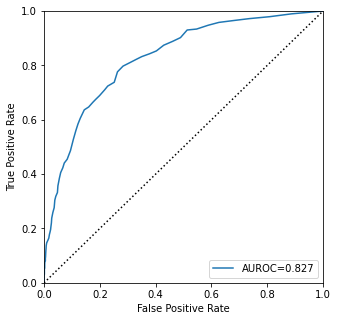

In [ ]:
# TODO: Plot ROC curve and calculate AUROC score
# ROC curve
fig, ax = plt.subplots(figsize=(5, 5))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='AUROC={:.3f}'.format(metrics.auc(fpr, tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], 'k:')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

In [ ]:
fi = pd.DataFrame({'feature': list(df_final.columns),
                   'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending = False)
top = fi.head(4)['feature'].values.tolist()

# visualize decision tree for top important features
names = top
df_top = df_final[top]
X_top = df_top.values

In [ ]:
# Pairplot
import seaborn as sns
# Create the pairplot
sns.pairplot(X_top, diag_kind = 'hist',
             plot_kws = {'alpha': 0.6, 's': 40, 'edgecolor': 'k'},
             height = 2)

TypeError: ignored

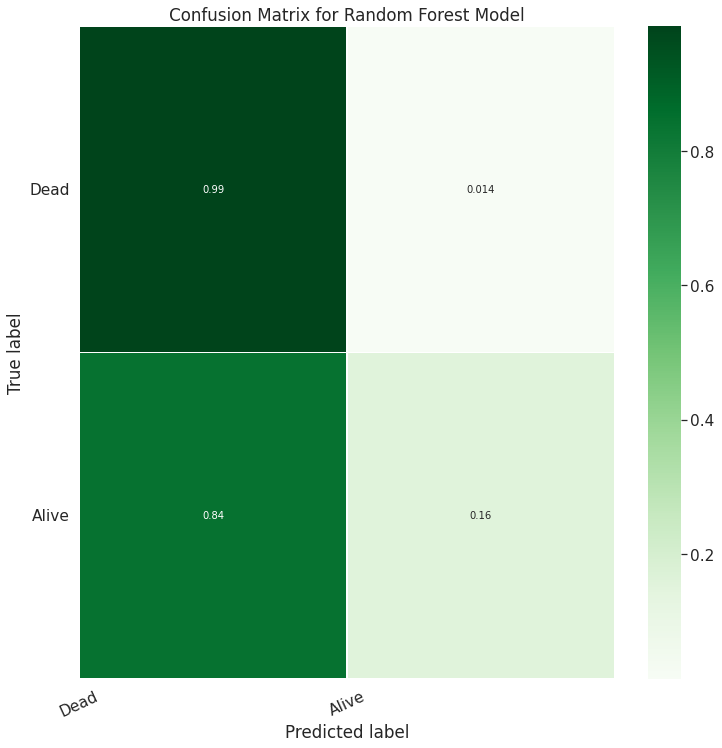

In [ ]:
#Confusion Matrix 1
import seaborn as sns

# Get and reshape confusion matrix data
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Dead', 'Alive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


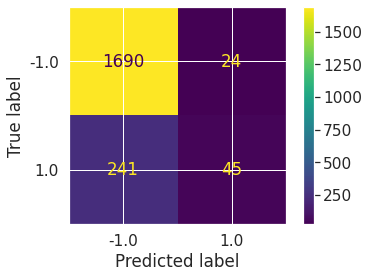

In [ ]:
#Another confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)
plt.show()